# SWE pre-processing
This Notebook reads SWE station observations and precipitation station data (SCDNA, 1979-2018 Version 1.1; the complete data is available on Zenodo [here](https://zenodo.org/record/3953310#.YXnGQS1b1mA)) for a test river basin. It fills the gaps in the SWE station observations that are within the river basin, using quantile mapping with neighbouring SWE and precipitation station data.

Decisions:
- We only use SWE and precipitation station data within the test river basin, and do not apply any buffer around the basin. A distance-decay plot could be used to check the optimal buffer size.
- The water year definition is October 1st to September 30th of the next year. See user-specified variables below.
- The minimum correlation allowed to select an optimal donor station is set to 0.6 at the moment (no negative correlations selected). See user-specified variables below.
- The minimum number of overlapping observations required to calculate the correlation between two stations is set to 3 at the moment. See user-specified variables below.
- The minimum number of observations required to calculate a station's cdf is set to 10 at the moment. See user-specified variables below.
- We use a time window of +/- 7 days on either side of the infilling date for gap filling calculations. See user-specified variables below.
- The minimum number of observations required to calculate the KGE'' is set to 3 at the moment. See user-specified variables below.
- We perform a linear interpolation of the daily discharge data before calculating volumes, to fill in small data gap of maximum 15 days. See user-specified variables below.
- We evaluate the artificial gap filling quality based on the RMSE and the KGE'' decomposition.

The "Variables" section below is the only section a user will need to modify for testing different options for most of these decisions.

Notes:
- We do not look at data stationarity.

## Modules, settings & functions

In [1]:
# Import required modules
import datetime
from datetime import timedelta
import geopandas as gpd
import logging
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
from shapely.geometry import Point
import sys
import warnings
import xarray as xr

In [2]:
# Add scripts to the system path
sys.path.append('../scripts')

# Set up logging, configured for this workflow (see utilities.py)
from utilities import setup_logging, read_settings
setup_logging()

# Set up logging for this notebook
logger = logging.getLogger()

# Suppress misc. comments from being added to the log file
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

# Get the logger for fiona._env and suppress everything below CRITICAL level
fiona_env_logger = logging.getLogger('fiona._env')
fiona_env_logger.setLevel(logging.CRITICAL)

%load_ext autoreload
%autoreload 2

2024-11-08 12:50:15,575 - root - INFO - Logging setup complete. Log file: C:\Users\lauri\PycharmProjects\FROSTBYTE_SW\logs\data_driven_forecasting_20241108_125015.log


In [3]:
# Save Notebook name to the log file
logger.debug(f'Notebook: 3_SWEPreprocessing')

In [4]:
# Read settings file
settings = read_settings('../settings/config_test_case.yaml', log_settings=True)
pprint(settings)

2024-11-08 12:50:15,757 - root - INFO - Settings logged from ../settings/config_test_case.yaml


{'SWE_obs_path': '../CAMELS_SW/input_data/SWE_SW.nc',
 'basins_dem_path': '../test_case_data/input_data/MERIT_Hydro_dem_',
 'basins_shp_path': '../CAMELS_SW/input_data/Sweden_catchments_50_boundaries_WGS84.shp',
 'domain': '1537',
 'output_data_path': '../CAMELS_SW/output_data/',
 'plots_path': '../CAMELS_SW/output_plots/',
 'precip_obs_path': '../CAMELS_SW/input_data/P_Camels_SW.nc',
 'streamflow_obs_path': '../CAMELS_SW/input_data/Q_Camels_SW.nc'}


In [5]:
# Import required functions
from functions import extract_stations_in_basin, stations_basin_map, data_availability_monthly_plots_1, data_availability_monthly_plots_2, qm_gap_filling, artificial_gap_filling, plots_artificial_gap_evaluation

## Variables

In [6]:
# Set user-specified variables
test_basin_id = settings['domain'] # Can override this with testbasin_id = <string of the testbasin id>, make sure that this id is in the input data files
flag_buffer_default, buffer_km_default = 0, 15 # buffer flag (0: no buffer around test basin, 1: buffer of value buffer_default around test basin) and buffer default value in km to be applied if flag = 1
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
min_obs_corr_default = 3 # the minimum number of overlapping observations required to calculate the correlation between 2 stations
min_obs_cdf_default = 10 # the minimum number of observations required to calculate a station's cdf
min_corr_default = 0.6 # the minimum correlation value required for donor stations to be selected
window_days_default = 7 # the number of days used on either side of the infilling date for gap filling calculations
min_obs_KGE_default = 3 # the minimum number of observations required to calculate the KGE''
max_gap_days_default = 15  # max. number of days for gaps allowed in the daily SWE data for the linear interpolation
iterations_default = 1 # the number of times we repeat the artificial gap filling (this should = 1 if artificial_gap_perc_default = 100, if artificial_gap_perc_default < 100, it can be set to > 1)
artificial_gap_perc_default = 100 # the percentage of observations to remove during the artificial gap filling for each station & month's first day

In [7]:
# Save the user-specified variables to the log file
logger.debug(f'test basin ID: {test_basin_id}')
logger.debug(f'buffer around basin for SWE and precip. stations selection (km): {buffer_km_default}')
logger.debug(f'water year start (month/day): {month_start_water_year_default}/{day_start_water_year_default}')
logger.debug(f'water year end (month/day): {month_end_water_year_default}/{day_end_water_year_default}')
logger.debug(f'min. number of obs. for correlation calculation: {min_obs_corr_default}')
logger.debug(f'min. number of obs. for building CDF: {min_obs_cdf_default}')
logger.debug(f'min. Pearson correlation for selection of donor stations: {min_corr_default}')
logger.debug(f'window length for infilling (days on either side of date): {window_days_default}')
logger.debug(f'min. number of obs. for KGE" calculation: {min_obs_KGE_default}')
logger.debug(f'linear interpolation maximum gap (days): {max_gap_days_default}')
logger.debug(f'percentage of observations to remove for artificial gap filling: {artificial_gap_perc_default}')

## Read data

In [8]:
# Read SWE station observations NetCDF
SWE_stations_ds = xr.open_dataset(settings['SWE_obs_path'])
SWE_stations_ds = SWE_stations_ds.assign_coords({'lon':SWE_stations_ds.lon, 'lat':SWE_stations_ds.lat, 'station_id':SWE_stations_ds.station_id}).swe
#SWE_stations_ds = SWE_stations_ds.assign_coords({'lon':SWE_stations_ds.lon, 'lat':SWE_stations_ds.lat, 'station_name':SWE_stations_ds.station_name}).snw
SWE_stations_ds = SWE_stations_ds.to_dataset()

display(SWE_stations_ds)

<xarray.Dataset>
Dimensions:     (station_id: 914, time: 26663)
Coordinates:
  * time        (time) datetime64[ns] 1949-09-01 1949-09-02 ... 2022-08-31
  * station_id  (station_id) int64 10001 10002 10003 10004 ... 11469 11470 11471
    lon         (station_id) float64 14.8 15.62 17.17 15.53 ... 17.9 11.7 14.22
    lat         (station_id) float64 56.87 60.62 65.07 58.4 ... 60.2 58.98 58.58
Data variables:
    swe         (time, station_id) float64 ...

In [9]:
# Convert SWE stations DataArray to GeoDataFrame for further analysis
"""
data = {'station_id': SWE_stations_ds.station_id.data, 
        'lon': SWE_stations_ds.lon.data, 
        'lat': SWE_stations_ds.lat.data} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

display(SWE_stations_gdf)
"""

print(SWE_stations_ds.station_id.data.shape)
print(SWE_stations_ds.lon.data.shape)
print(SWE_stations_ds.lat.data.shape)
data = {'station_id': SWE_stations_ds.station_id.data, 
        'lon': SWE_stations_ds.lon.data, 
        'lat': SWE_stations_ds.lat.data} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "epsg:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

#SWE_stations_gdf_lv95 = SWE_stations_gdf.to_crs("EPSG:2056")

display(SWE_stations_gdf)



(914,)
(914,)
(914,)


,station_id,lon,lat,geometry
0,10001,14.80000,56.86667,POINT (14.80000 56.86667)
1,10002,15.61667,60.61667,POINT (15.61667 60.61667)
2,10003,17.16639,65.06667,POINT (17.16639 65.06667)
3,10004,15.53306,58.40000,POINT (15.53306 58.40000)
4,10005,15.53306,58.40000,POINT (15.53306 58.40000)
...,...,...,...,...
909,11467,17.09806,61.26917,POINT (17.09806 61.26917)
910,11468,17.20000,59.11667,POINT (17.20000 59.11667)
911,11469,17.89639,60.19944,POINT (17.89639 60.19944)
912,11470,11.69500,58.97639,POINT (11.69500 58.97639)


In [10]:
"""#LNU koordinaten in LV95 umwandeln
# Überprüfen der Dimensionen der Datenarrays
print(SWE_stations_ds.station_id.data.shape)
print(SWE_stations_ds.lon.data.shape)
print(SWE_stations_ds.lat.data.shape)

# Erstellen des DataFrames
data = {
    'station_id': SWE_stations_ds.station_id.data,
    'lon': SWE_stations_ds.lon.data,
    'lat': SWE_stations_ds.lat.data
}
df = pd.DataFrame(data)

# Erstellen der Geometrien
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# Definieren des ursprünglichen Koordinatensystems (EPSG:21781)
crs = "epsg:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

# Anzeigen des ursprünglichen GeoDataFrame
print("Vor der Umwandlung (epsg:4326):")
display(SWE_stations_gdf)

# Umwandeln in das neue Koordinatensystem (EPSG:2056)
SWE_stations_gdf_lv95 = SWE_stations_gdf.to_crs("epsg:4326")

# Anzeigen des umgewandelten GeoDataFrame
print("Nach der Umwandlung (epsg:4326):")
display(SWE_stations_gdf_lv95)

# Überprüfung der Koordinaten nach Umwandlung
print("Umgewandelte Koordinaten (epsg:4326):")
print(SWE_stations_gdf_lv95[['geometry']])
SWE_stations_gdf = SWE_stations_gdf_lv95
"""

'#LNU koordinaten in LV95 umwandeln\n# Überprüfen der Dimensionen der Datenarrays\nprint(SWE_stations_ds.station_id.data.shape)\nprint(SWE_stations_ds.lon.data.shape)\nprint(SWE_stations_ds.lat.data.shape)\n\n# Erstellen des DataFrames\ndata = {\n    \'station_id\': SWE_stations_ds.station_id.data,\n    \'lon\': SWE_stations_ds.lon.data,\n    \'lat\': SWE_stations_ds.lat.data\n}\ndf = pd.DataFrame(data)\n\n# Erstellen der Geometrien\ngeometry = [Point(xy) for xy in zip(df[\'lon\'], df[\'lat\'])]\n\n# Definieren des ursprünglichen Koordinatensystems (EPSG:21781)\ncrs = "epsg:4326"\nSWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)\n\n# Anzeigen des ursprünglichen GeoDataFrame\nprint("Vor der Umwandlung (epsg:4326):")\ndisplay(SWE_stations_gdf)\n\n# Umwandeln in das neue Koordinatensystem (EPSG:2056)\nSWE_stations_gdf_lv95 = SWE_stations_gdf.to_crs("epsg:4326")\n\n# Anzeigen des umgewandelten GeoDataFrame\nprint("Nach der Umwandlung (epsg:4326):")\ndisplay(SWE_stations_

In [11]:
# Plot SWE stations available

# Load the world map
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for Sweden
sweden_gdf = world_gdf[world_gdf['name'] == 'Sweden']

# Plot the map of Sweden in WGS84 (no need to transform as naturalearth_lowres is already in WGS84)
ax = sweden_gdf.plot(linewidth=1, edgecolor='grey', color='white')

# Assume SWE_stations_gdf is already loaded and contains Swedish SWE stations in WGS84
# Filter the stations for Sweden, if necessary
# SWE_stations_gdf = SWE_stations_gdf[SWE_stations_gdf['country'] == 'Sweden'] # Optional filter if country column exists

# Plot the SWE stations on the Sweden map
SWE_stations_gdf.plot(ax=ax, color='b', alpha=.5, markersize=5)

# Set plot boundaries based on Sweden's coordinates
minx, miny, maxx, maxy = sweden_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Adjust plot details
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('SWE stations available in Sweden (WGS84)')
plt.text(.01, .01, 'Total stations=' + str(len(SWE_stations_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)
plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>

You can zoom into the map with the rectangle icon ("zoom to rectangle") showing below the figure. Here, you see that the sample data contains SWE station observations for an area around two river basins, one in the USA and one in Canada, for which we also have all the data needed to run this workflow (e.g., discharge observations).

In [12]:
# Read meteorological station observations NetCDF
met_stations_ds = xr.open_dataset(settings['precip_obs_path'])

display(met_stations_ds)
print(met_stations_ds.LLE)

<xarray.Dataset>
Dimensions:        (lle: 3, nday: 21915, station: 50)
Coordinates:
  * nday           (nday) datetime64[ns] 1961-01-01 1961-01-02 ... 2020-12-31
  * station        (station) object '1069' '1083' '1123' ... '751' '855' '97'
  * lle            (lle) object 'lon' 'lat' 'elev'
Data variables:
    precipitation  (station, nday) float64 ...
    LLE            (station, lle) float64 ...

<xarray.DataArray 'LLE' (station: 50, lle: 3)>
array([[ 14.125332,  56.662256, 165.681843],
       [ 12.12667 ,  62.639165, 942.431997],
       [ 21.806885,  66.171259, 254.843159],
       [ 13.139745,  57.436259, 232.868247],
       [ 12.6109  ,  62.5454  , 893.761363],
       [ 12.439714,  61.819982, 757.800487],
       [ 14.062515,  58.597271, 207.593562],
       [ 13.041991,  58.320057, 180.848754],
       [ 12.351615,  58.621062, 152.05836 ],
       [ 16.6994  ,  58.8585  ,  68.863935],
       [ 13.0134  ,  63.7355  , 637.897197],
       [ 12.786158,  63.439112, 747.49065 ],
       [ 14.111506,  64.065133, 623.141354],
       [ 11.65307 ,  58.790102, 174.784724],
       [ 16.75027 ,  63.642282, 285.174658],
       [ 16.4659  ,  59.3221  ,  67.393135],
       [ 18.8272  ,  66.6526  , 645.39075 ],
       [ 19.888   ,  65.342   , 436.080221],
       [ 14.239355,  64.838554, 783.809607],
       [ 13.1244  ,  56.7157  , 165.083632],
       [ 18.299047,  63.433514, 285.712419],
       [

In [13]:
# LNU --> nstn hinzufügen
#Erstelle eine neue durchnummerierte Variable für 'nstn'
nstn_values = np.arange(met_stations_ds.dims['station'])  # Erzeugt eine Liste [0, 1, 2, ..., N-1], wobei N die Anzahl der Stationen ist

# Füge diese Variable als 'nstn' hinzu
met_stations_ds['nstn'] = xr.DataArray(nstn_values, dims=['station'])

display(met_stations_ds)

<xarray.Dataset>
Dimensions:        (lle: 3, nday: 21915, station: 50)
Coordinates:
  * station        (station) object '1069' '1083' '1123' ... '751' '855' '97'
  * nday           (nday) datetime64[ns] 1961-01-01 1961-01-02 ... 2020-12-31
  * lle            (lle) object 'lon' 'lat' 'elev'
Data variables:
    precipitation  (station, nday) float64 ...
    LLE            (station, lle) float64 14.13 56.66 165.7 ... 62.82 365.6
    nstn           (station) int32 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49

In [14]:
# LNU ich versuche "Convert meteorological stations DataSet to GeoDataFrame for further analysis"
lon = met_stations_ds.LLE[:, 0].values  # Extract longitude
lat = met_stations_ds.LLE[:, 1].values  # Extract latitude
elev = met_stations_ds.LLE[:, 2].values  # Extract elevation
station = met_stations_ds.station[:].values

# Step 2: Create a DataFrame
data = {
    'lon': lon, 
    'lat': lat,
    'elev': elev,
    'station': station
}
df = pd.DataFrame(data)

# Step 3: Create geometry for GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# Step 4: Create the GeoDataFrame (ensure correct CRS)
# If your coordinates are in EPSG:21781, set crs accordingly
met_stations_gdf = gpd.GeoDataFrame(df, crs="epsg:4326", geometry=geometry)

# Display the GeoDataFrame
print(met_stations_gdf)

          lon        lat        elev station                   geometry
0   14.125332  56.662256  165.681843    1069  POINT (14.12533 56.66226)
1   12.126670  62.639165  942.431997    1083  POINT (12.12667 62.63917)
2   21.806885  66.171259  254.843159    1123  POINT (21.80688 66.17126)
3   13.139745  57.436259  232.868247    1166  POINT (13.13975 57.43626)
4   12.610900  62.545400  893.761363    1169  POINT (12.61090 62.54540)
5   12.439714  61.819982  757.800487    1171  POINT (12.43971 61.81998)
6   14.062515  58.597271  207.593562    1221  POINT (14.06251 58.59727)
7   13.041991  58.320057  180.848754    1236  POINT (13.04199 58.32006)
8   12.351615  58.621062  152.058360    1243  POINT (12.35161 58.62106)
9   16.699400  58.858500   68.863935    1273  POINT (16.69940 58.85850)
10  13.013400  63.735500  637.897197    1309  POINT (13.01340 63.73550)
11  12.786158  63.439112  747.490650    1328  POINT (12.78616 63.43911)
12  14.111506  64.065133  623.141354    1341  POINT (14.11151 64

In [15]:
# Plot meteorological stations available
# Load the world map data
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the map data for Sweden
sweden_gdf = world_gdf[world_gdf['name'] == 'Sweden']

# Plot setup
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the map of Sweden (already in WGS84, EPSG:4326)
sweden_gdf.plot(ax=ax, linewidth=0.5, edgecolor='grey', color='lightgrey')

# Plot the meteorological station data points (assumed to be in WGS84)
# Ensure met_stations_gdf is in WGS84; if needed, use .to_crs(epsg=4326) to transform
plt.scatter(met_stations_gdf.geometry.x, met_stations_gdf.geometry.y, color='b', alpha=0.5, s=5)

# Set axis limits based on Sweden's bounds
minx, miny, maxx, maxy = sweden_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Further plot settings
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')

# Add title and station count text
plt.title('Meteorological Stations in Sweden (WGS84 Coordinate System)')
plt.text(0.01, 0.01, f'Total stations={len(met_stations_gdf.index)}', ha='left', va='bottom', transform=ax.transAxes)

plt.tight_layout()
plt.show()



<IPython.core.display.Javascript object>

Same comments as for the SWE map above. Note that not all meteorological stations contained in this dataset have precipitation data. Some only have temperature for example. We will sort out the stations with precipitation later in this workflow.

## Extract SWE and precipitation stations in the basin

In [16]:
# Read test basin's shapefile
basins_gdf = gpd.read_file(settings['basins_shp_path'])
shp_testbasin_gdf = basins_gdf.loc[basins_gdf.id.astype(str) == test_basin_id]
#basins_gdf['gauge_id'] = basins_gdf['gauge_id'].astype(str)
#shp_testbasin_gdf = basins_gdf.loc[basins_gdf.gauge_id == test_basin_id]

print("basins_gdf:")
print(basins_gdf.dtypes)  # Zeigt die Datentypen des basins_gdf
print("Datentyp test_basin_id:")
print(type(test_basin_id))  # Zeigt den Datentyp von test_basin_id

display(shp_testbasin_gdf)

basins_gdf:
id             int64
name          object
area         float64
latlon_1     float64
latlon_2     float64
geometry    geometry
dtype: object
Datentyp test_basin_id:
<class 'str'>


,id,name,area,latlon_1,latlon_2,geometry
9,1537,ANKARVATTNET,427.8,64.8361,14.2388,"POLYGON ((14.35659 64.86047, 14.34517 64.85829..."


In [17]:
# Plot a map of the test basin and of the SWE and meteorological stations available
print("CRS von shp_testbasin_gdf:", shp_testbasin_gdf.crs)
print("CRS von SWE_stations_gdf:", SWE_stations_gdf.crs)
print("CRS von met_stations_gdf:", met_stations_gdf.crs)
shp_testbasin_gdf = shp_testbasin_gdf.rename(columns={"id": "Station_ID"})
shp_testbasin_gdf = shp_testbasin_gdf.rename(columns={"name": "Station_Na"})
shp_testbasin_gdf['Station_ID'] = shp_testbasin_gdf['Station_ID'].astype(str)
fig = stations_basin_map(shp_testbasin_gdf, test_basin_id, SWE_stations_gdf, met_stations_gdf, flag=flag_buffer_default, buffer_km=buffer_km_default)

CRS von shp_testbasin_gdf: epsg:4326
CRS von SWE_stations_gdf: epsg:4326
CRS von met_stations_gdf: epsg:4326


<IPython.core.display.Javascript object>

We will now extract the SWE and meteorological stations that fall within the basin only.

In [18]:
# Extract SWE stations within test basin (+ optional buffer) and save info to DataFrame
print(SWE_stations_gdf.crs)
print(shp_testbasin_gdf.crs)
SWE_stations_in_basin = extract_stations_in_basin(SWE_stations_gdf, shp_testbasin_gdf, test_basin_id, buffer_km=buffer_km_default)[0]

display(SWE_stations_in_basin)

print('There are',str(len(SWE_stations_in_basin.index)),'SWE stations within the test basin.')

epsg:4326
epsg:4326


,station_id,lon,lat,geometry,basin
317,10804,14.25,64.87000,POINT (14.25000 64.87000),1537
836,11323,14.15,64.81973,POINT (14.15000 64.81973),1537
838,11325,14.23,64.87972,POINT (14.23000 64.87972),1537
840,11327,14.16,64.93000,POINT (14.16000 64.93000),1537


There are 4 SWE stations within the test basin.


In [19]:
# Extract meteorological stations within test basin (+ optional buffer) and save info to DataFrame
met_stations_in_basin = extract_stations_in_basin(met_stations_gdf, shp_testbasin_gdf, test_basin_id, buffer_km=buffer_km_default)[0]

display(met_stations_in_basin)

print('There are',str(len(met_stations_in_basin.index)),'meteorological stations within the test basin.')

,lon,lat,elev,station,geometry,basin
18,14.239355,64.838554,783.809607,1537,POINT (14.23936 64.83855),1537


There are 1 meteorological stations within the test basin.


In [20]:
# Plot map of test basin (+ optional buffer) and the extracted stations
fig = stations_basin_map(shp_testbasin_gdf, test_basin_id, SWE_stations_in_basin, met_stations_in_basin, flag=flag_buffer_default, buffer_km=buffer_km_default)

<IPython.core.display.Javascript object>

We will now extract the SWE station observations in the test basin and make a few plots.

In [21]:
# Sub-select SWE station observations in test basin and convert to Pandas DataFrame
print(SWE_stations_ds)
SWE_testbasin_ds = SWE_stations_ds.sel(station_id = SWE_stations_in_basin["station_id"].values)

# Convert test basin SWE data DataSet to Pandas DataFrame for further analysis
SWE_testbasin_df = SWE_testbasin_ds.to_dataframe().drop(columns=['lon','lat']).unstack()['swe'].T
#SWE_testbasin_df = SWE_testbasin_ds.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw'].T
SWE_testbasin_df['date'] = SWE_testbasin_df.index.normalize()
SWE_testbasin_df = SWE_testbasin_df.set_index('date')

display(SWE_testbasin_df)

<xarray.Dataset>
Dimensions:     (station_id: 914, time: 26663)
Coordinates:
  * time        (time) datetime64[ns] 1949-09-01 1949-09-02 ... 2022-08-31
  * station_id  (station_id) int64 10001 10002 10003 10004 ... 11469 11470 11471
    lon         (station_id) float64 14.8 15.62 17.17 15.53 ... 17.9 11.7 14.22
    lat         (station_id) float64 56.87 60.62 65.07 58.4 ... 60.2 58.98 58.58
Data variables:
    swe         (time, station_id) float64 ...


station_id,10804,11323,11325,11327
date,,,,
1949-09-01,0.0,0.0,0.0,0.0
1949-09-02,0.0,0.0,0.0,0.0
1949-09-03,0.0,0.0,0.0,0.0
1949-09-04,0.0,0.0,0.0,0.0
1949-09-05,0.0,0.0,0.0,0.0
...,...,...,...,...
2022-08-27,NaN,NaN,NaN,NaN
2022-08-28,NaN,NaN,NaN,NaN
2022-08-29,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


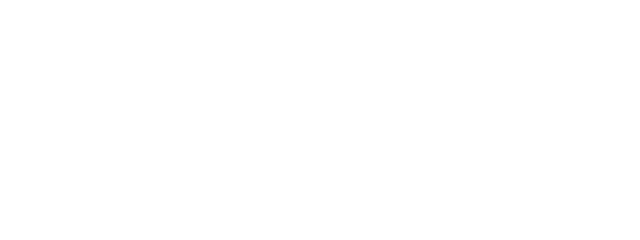

In [22]:
# Plot timeseries of SWE station observations in the test basin
fig = plt.figure(figsize=(8,3))

for s in SWE_testbasin_ds.station_id.values:
    SWE_testbasin_ds.swe.sel(station_id = s).plot(marker='o', alpha=.3, markersize=1, label=s)

plt.title('')
plt.ylabel('SWE [mm]')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1,1.1), loc='upper left', fontsize=8)
plt.tight_layout();

In [23]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_timeseries_basin"+test_basin_id+".png", dpi=300)

In [24]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

<IPython.core.display.Javascript object>


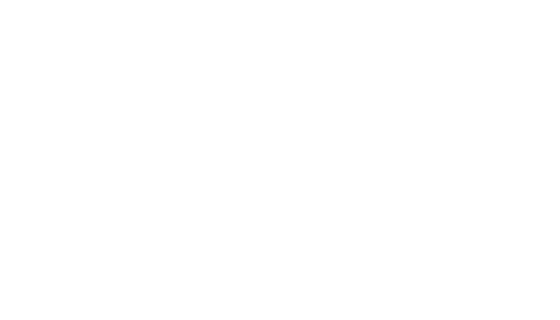

In [25]:
# Plot timeseries of test basin SWE observations climatological means
# We expect to see warnings as some days of the year only have missing values
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    fig = plt.figure(figsize=(7,4))

    for s in SWE_testbasin_ds.station_id.values:
        testbasin_SWE_climatology_means = SWE_testbasin_ds.swe.sel(station_id = s).groupby("time.dayofyear").mean(dim=xr.ALL_DIMS, skipna=True)
        testbasin_SWE_climatology_means.plot(marker='o', alpha=.3, markersize=3, label=s)

    plt.title('')
    plt.xticks(np.linspace(0,366,13)[:-1], ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
    plt.xlabel('')
    plt.ylabel('SWE [mm]')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.tight_layout();

We can see a striking difference in data availability between the more continuous automatic stations and the discontinuous manual surveys.

In [26]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_mean_climatology_basin"+test_basin_id+".png", dpi=300)

In [27]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

<IPython.core.display.Javascript object>


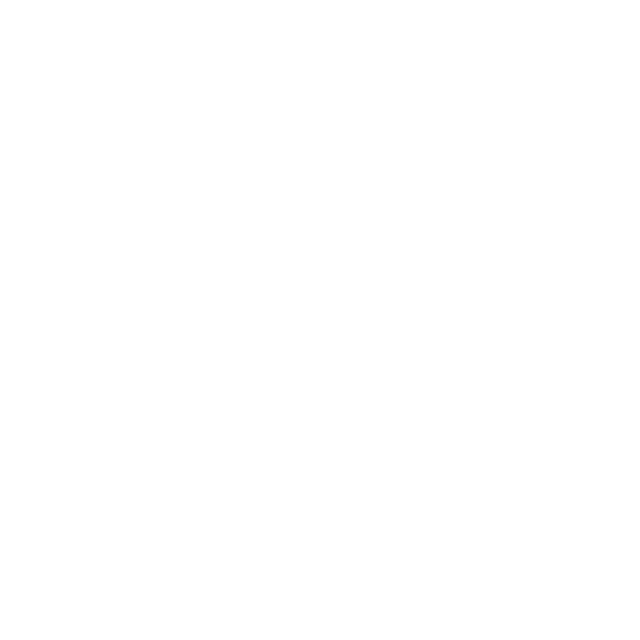

In [28]:
# Plot timeseries of the % of SWE stations with data in the test basin on the first day of each month
fig = data_availability_monthly_plots_1(SWE_stations_in_basin, SWE_testbasin_ds.swe, None, flag=0)

This shows timeseries of the percentage of all SWE stations in the test basin that actually have observations on the first day of each month (subplots). E.g., if all stations have data on the 1st of June 2000, the corresponding bar should show 100%. The reason we focus on the first of each month is because we will only be using these data as they correspond to the hindcast start dates (generated in the next Notebook). 

In [29]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_1_basin"+test_basin_id+".png", dpi=300)

In [30]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

We understand that SWE measurements may not always be taken on the first of the month if they are manual measurements. In order to check how far from the first of each month measurements are taken within the test basin, we plot the SWE observations available around the first of day of each month.

<IPython.core.display.Javascript object>


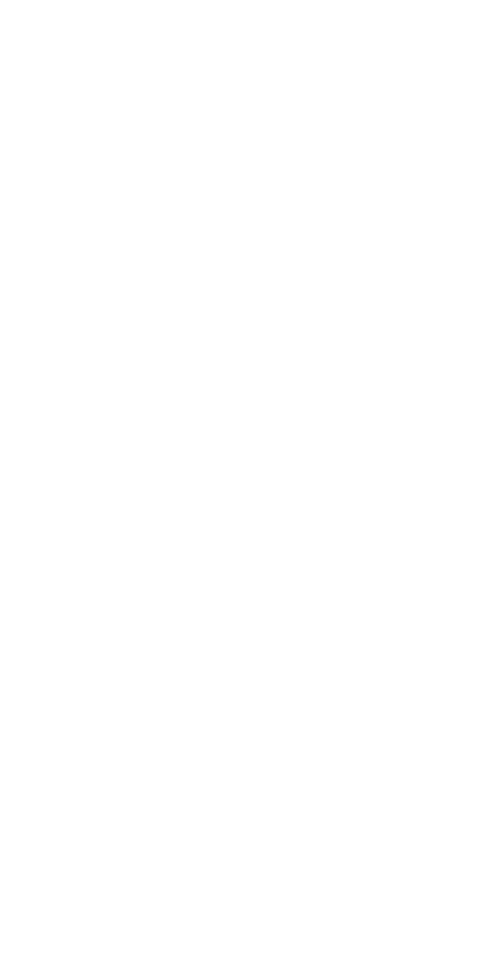

In [31]:
# Plot bar charts of the days with SWE observations around the first day of each month
SWE_testbasin_df.columns = SWE_testbasin_df.columns.map(str)
fig = data_availability_monthly_plots_2(SWE_testbasin_df)

For the Bow at Banff, it looks like most of the manual SWE measurements are taken within a +/- 7 day window around the first day of each month during the snow accumulation period. These results could help us refine the time window used for the infilling (see user-specified variable at the top of this Notebook).

In [32]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_2_basin"+test_basin_id+".png", dpi=300)

In [33]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

## Pre-process the SWE and precipitation basin datasets

### Precipitation pre-processing

We will first need to calculate water year station cumulative precipitation outputs to use as a proxy for SWE during the infilling step later on.

In [34]:

# Plot a bar chart of the number of times each donor station was used for infilling
count = []

for s in SWE_P_testbasin_df.columns.values:
    count_s = SWE_testbasin_gapfilled_ds.donor_stations.where(SWE_testbasin_gapfilled_ds.donor_stations==s).count().data
    count.append(count_s)

fig = plt.figure()
plt.bar(SWE_P_testbasin_df.columns.values, count, color='b')
plt.xticks(rotation=90)
plt.xlabel('Donor stations')
plt.ylabel('# times used for infilling')
plt.tight_layout();



NameError: name 'SWE_P_testbasin_df' is not defined

In [ ]:

# Save the figure
fig.savefig(settings['plots_path']+"donor_stations_gapfilling_basin"+test_basin_id+".png", dpi=300)

In [ ]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

In [ ]:
# Station IDs in SWE_testbasin_ds konvertieren
SWE_testbasin_ds.swe = SWE_testbasin_ds.swe.assign_coords(station_id=SWE_testbasin_ds.swe.station_id.astype(str))

# Station IDs in SWE_testbasin_gapfilled_ds konvertieren
SWE_testbasin_gapfilled_ds.SWE = SWE_testbasin_gapfilled_ds.SWE.assign_coords(station_id=SWE_testbasin_gapfilled_ds.SWE.station_id.astype(str))

In [ ]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_1_after_gap_filling_basin"+test_basin_id+".png", dpi=300)

In [ ]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

### Artificial gap filling and evaluation
We remove data artificially from the SWE station observations to test the performance of the gap filling. Note that we only do this for the first of each month to limit the computation time.

In [ ]:
# Plot artificial gap filling evaluation results
fig = plots_artificial_gap_evaluation(evaluation_artificial_gapfill_testbasin_dict)

The boxplots contain results for all SWE stations. For the Bow at Banff, we can see some low scores. This can sometimes happens for certain SWE stations with very few gaps to fill. If various donor stations are used to fill out these gaps, then there are some inconsistencies across infilling values and the overall correlation between the infilling values and the observations is poor.

## Save data
Save the output gap-filled SWE data so we can read them in other Notebooks.

In [ ]:
# Save the data
# SWE_testbasin_gapfilled_ds.to_netcdf(settings['output_data_path']+"SWE_1979_2022_gapfilled_basin"+test_basin_id+".nc", format="NETCDF4")

In [35]:

try:
    # Prüfen, ob 'SWE_testbasin_gapfilled_ds' definiert ist
    SWE_testbasin_gapfilled_ds.to_netcdf(
        settings['output_data_path'] + "SWE_1979_2022_gapfilled_basin" + test_basin_id + ".nc",
        format="NETCDF4"
    )
except NameError:
    # Wenn 'SWE_testbasin_gapfilled_ds' nicht definiert ist
    SWE_testbasin_ds.to_netcdf(
        settings['output_data_path'] + "SWE_1979_2022_gapfilled_basin" + test_basin_id + ".nc",
        format="NETCDF4"
    )

In [ ]:
display(SWE_testbasin_ds)